**Experiments**

1)Basic model: Val acc: 70.49 Kaggle score: 66.055 <br>
2)Basic model (with augmentation): Val acc: 70.26 Kaggle score: 67.380 <br>
2)Pretrained Resnet18-3d (without augmentation) Val acc: 86 Kaggle Score: 81.039 <br>
3)Pretrained Resnet18-3d (with augmentation) Val acc: 87.71 Kaggle Score: **82.059** <br>
4)Pretrained Resnet18-3d (with augmentation, minor changes in parameters) Val acc: 85.20 Kaggle Score: 80.937 <br>
3)Pretrained Resnet18-3d (with augmentation) train + val data Kaggle Score: **83.792** <br>

I have lost few outputs while finetuning on same code again and again. Few are having **training progress in curves**. All the experiments lie in this notebook. <br>
All these self designed models gave validation accuracy moving around 60 to 70 and kaggle accuracy 60 to 65. Experiments included, <br>
changing optimizer(Adam, RMSprop, SGD), <br>
activation function (relu, leakyrelu), <br>
modifying optimizer parameters (weight decay, momentum, Nesterov) <br>
augmentation, <br>
using already trained model with lower learning rate <br>
Here I spent most of the time as I was not able to use pretrained models eariler. <br>
<br>
First try with pretrained resnet with last layer changed gave best performance. This was very late so could not explore much with it.

In [1]:
%matplotlib inline  
from matplotlib import pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader,sampler,Dataset
import torchvision.datasets as dset
import torchvision.transforms as T
import timeit
from PIL import Image
import os
import numpy as np
import scipy.io
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
from models.resnet import get_fine_tuning_parameters
from IPython.display import clear_output

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [3]:
# cd '/content/gdrive/My Drive/ML/hw6/again/Question2/'

In [4]:
label_mat=scipy.io.loadmat('./data/q3_2_data.mat')
label_train=label_mat['trLb']
print(len(label_train))
label_val=label_mat['valLb']
print(len(label_val))

7770
2230


In [5]:
import gc
def clean():
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
class ActionClipDataset(Dataset):
    """Action Landmarks dataset."""

    def __init__(self,  root_dir,labels=[], transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.root_dir = root_dir
        self.transform = transform
        self.length=len(os.listdir(self.root_dir))
        self.labels=labels

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        folder=idx+1
        folder=format(folder,'05d')
        clip=[]
        if len(self.labels)!=0:
            Label=self.labels[idx][0]-1
        for i in range(3):
            imidx=i+1
            imgname=str(imidx)+'.jpg'
            img_path = os.path.join(self.root_dir,
                                    folder,imgname)
            image = Image.open(img_path)
            image=np.array(image)
            clip.append(image)
        if self.transform:
            clip=np.asarray(clip)
            clip=np.transpose(clip, (0,3,1,2))
            clip = torch.from_numpy(np.asarray(clip))
        if len(self.labels)!=0:
            sample={'clip':clip,'Label':Label,'folder':folder}
        else:
            sample={'clip':clip,'folder':folder}
        return sample

In [7]:
dtype = torch.cuda.FloatTensor
class Flatten3d(nn.Module):
    def forward(self, x):
        ###############6th TODO (3 points)###################
        return x.view(x.size()[0], -1)
def check_accuracy_3d(model, loader, pretrained=None):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(loader):
        if t+1 % 1100==0:
            print('wait')
        x_var = Variable(sample['clip'].type(dtype))
        y_var = sample['Label'].type(dtype)
        model = model.type(dtype)
        y_var=y_var.cpu()
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc * 100

def predict_on_test_3d(model, loader, pretrained=None):
    '''
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')  
    '''
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    results=open('results_3d.csv','w')
    count=0
    results.write('Id'+','+'Class'+'\n')
    for t, sample in enumerate(loader):
        x_var = Variable(sample['clip'].type(dtype))
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)
        _, preds = scores.data.max(1)
        for i in range(len(preds)):
            results.write(str(count)+','+str(preds[i].cpu().detach().numpy())+'\n')
            count+=1
    results.close()
    return count
    

1) Tried simple model without padding and stride which did not perform well.
After few tries, designed the below architecture which gained 60+ accuracy

In [17]:
fixed_model_3d = nn.Sequential(
    
    nn.Conv3d(3, 16, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(16),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    nn.Conv3d(16, 32, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(32),
    nn.ReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    nn.Conv3d(32, 64, kernel_size=(2, 3, 3), padding=0),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    
    nn.Conv3d(64, 64, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    Flatten3d(),
    nn.LeakyReLU(),
    nn.BatchNorm1d(32768),
    nn.Linear(32768, 10)
)

In [ ]:
model = fixed_model_3d
pretrained = None

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.09)

train_tf = T.Compose([
    T.ToTensor()
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=8,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 50
PATH = 'saved_models/3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "=> Best Till now", best_acc)
    

2) Loaded previous architecture with best weights trained in previous experiment, used image augmentation.

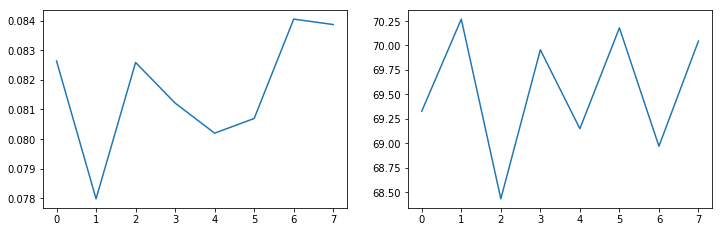

Epoch 8 =>  Val acc: 70.04484304932735 => Best Till now 70.26905829596413
t = 200, loss = 0.2661
t = 400, loss = 0.1780


In [ ]:
model = torch.load('saved_models/3d_70.49.pt')
model
pretrained = None
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.09)

train_tf = T.Compose([
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
        T.RandomRotation(30),
        T.RandomPerspective()
    ]),
])
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=8,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 70
PATH = 'saved_models/3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "=> Best Till now", best_acc)
    

In [15]:
clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())
clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=1,
                        shuffle=False, num_workers=0)
fixed_model_3d = torch.load('saved_models/3d_70.49.pt')
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270


All these self designed models gave validation accuracy moving around 60 to 70 and kaggle accuracy 60 to 65. Experiments included <br>changing optimizer(Adam, RMSprop, SGD), <br>activation function (relu, leakyrelu), <br>modifying optimizer parameters (weight decay, momentum, Nesterov)<br> regularization, <br> using already trained model with lower learning rate

3) Started using pretrained resnet 3d, without normalisation it reached 83 val acc, with normalisation it improved to 86 val acc. This gave me **81 acc on kaggle**.

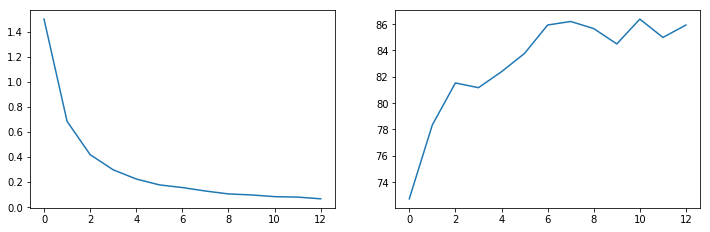

Epoch 13 =>  Val acc: 85.91928251121075 => Best Till now 86.3677130044843


KeyboardInterrupt: 

In [47]:
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.9)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=12,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=12,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/Norm3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "=> Best Till now", best_acc)

4) Added image augmentation with pretrained model resnet

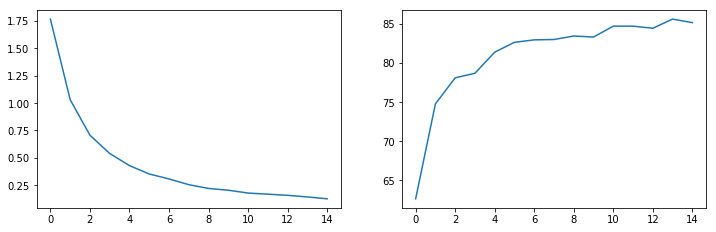

Epoch 15 =>  Val acc: 85.1121076233184 => Best Till now 87.71


In [10]:
# model = nn.Linear(400,10)
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None

# model = torch.load('saved_models/Norm3d_85.91.pt')


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.8)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
#         T.RandomRotation(45),
#         T.RandomPerspective(),
#         T.RandomErasing(p = 0.8, value = 'random'),
    ]),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=10,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=10,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 87.71
PATH = 'saved_models/Norm3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "=> Best Till now", best_acc)


In [11]:
torch.save(model, '2d_secondGood_85.11.pth')

c:\users\karan\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type VideoResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\karan\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BasicStem. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\karan\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv3d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
c:\users\karan\appdata\local\programs\python\python36\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Ba

5) Few changes in learning rate, weight decay.

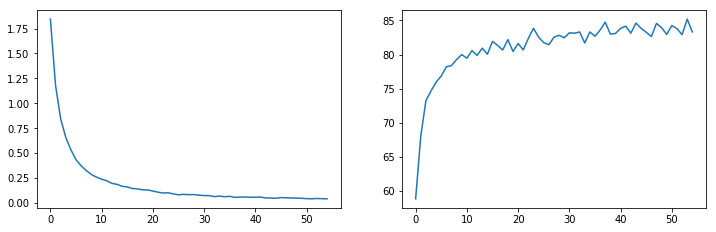

Epoch 55 =>  Val acc: 83.31 => Best Till now 85.20179372197309


In [12]:
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None

# model = torch.load('saved_models/Norm3d_85.91.pt')


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=0.8*1e-4, momentum = 0.8, weight_decay = 0.01)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
#         T.RandomRotation(45),
#         T.RandomPerspective(),
#         T.RandomErasing(p = 0.8, value = 'random'),
    ]),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=10,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=10,
                        shuffle=False, num_workers=0)

num_epochs = 55
train_losses = []
val_losses = []
val_accs = []
best_acc = 82
PATH = 'saved_models/Norm3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", str(acc)[:5], "=> Best Till now", best_acc)


**train = train + val**

**Kaggle Score:0.83792**

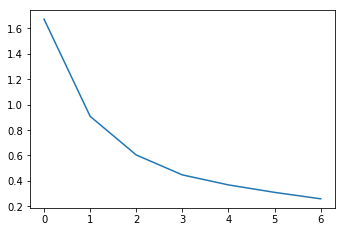

Epoch 7 =>  Train Loss: 0.258
t = 200, loss = 0.0517


KeyboardInterrupt: 

In [22]:
# model = nn.Linear(400,10)
import torchvision
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None

# model = torch.load('saved_models/Norm3d_85.91.pt')


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.8)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
#         T.RandomRotation(45),
#         T.RandomPerspective(),
#         T.RandomErasing(p = 0.8, value = 'random'),
    ]),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=10,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=10,
                        shuffle=False, num_workers=0)

merged = torch.utils.data.ConcatDataset([clip_dataset_train, clip_dataset_val])

clip_dataloader_trainMega = DataLoader(merged, batch_size=10,
                        shuffle=True, num_workers=0)

num_epochs = 15
train_losses = []
# val_losses = []
# val_accs = []
# best_acc = 82
PATH = 'saved_models/Norm3dM_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_trainMega):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
#     acc = check_accuracy_3d(model, clip_dataloader_trainMega, pretrained=pretrained)

#     val_losses.append(np.mean(np.array(losses)))
    
#     val_accs.append(acc)
    
#     if acc > best_acc:
#         best_acc = acc
    torch.save(model, PATH.format(str(epoch+1)))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
#         plt.subplot(222)
#         plt.plot(train_losses)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Train Loss:", str(train_losses[-1])[:5])


In [ ]:
# model = nn.Linear(400,10)
import torchvision
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None

model = torch.load('saved_models/Norm3dM_7.pt')


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.8)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
#         T.RandomRotation(45),
#         T.RandomPerspective(),
#         T.RandomErasing(p = 0.8, value = 'random'),
    ]),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=2,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=2,
                        shuffle=False, num_workers=0)

merged = torch.utils.data.ConcatDataset([clip_dataset_train, clip_dataset_val])

clip_dataloader_trainMega = DataLoader(merged, batch_size=2,
                        shuffle=True, num_workers=0)

num_epochs = 15
train_losses = []
# val_losses = []
# val_accs = []
# best_acc = 82
PATH = 'saved_models/Norm3dM_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_trainMega):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
#     acc = check_accuracy_3d(model, clip_dataloader_trainMega, pretrained=pretrained)

#     val_losses.append(np.mean(np.array(losses)))
    
#     val_accs.append(acc)
    
#     if acc > best_acc:
#         best_acc = acc
    torch.save(model, PATH.format(str(epoch+7)))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
#         plt.subplot(222)
#         plt.plot(train_losses)
        plt.show()
        print("Epoch", epoch+7, "=> ", "Train Loss:", str(train_losses[-1])[:5])


t = 200, loss = 0.5646
t = 400, loss = 0.5366
t = 600, loss = 0.4047
t = 800, loss = 1.8214
t = 1000, loss = 0.3229
t = 1200, loss = 1.4839
t = 1400, loss = 0.9191
t = 1600, loss = 0.2833
t = 1800, loss = 3.4267
t = 2000, loss = 0.2896
t = 2200, loss = 1.6974
t = 2400, loss = 3.0799
t = 2600, loss = 2.5576
t = 2800, loss = 0.6391
t = 3000, loss = 0.4811
t = 3200, loss = 0.4724
t = 3400, loss = 0.1958


In [ ]:
# model = nn.Linear(400,10)
import torchvision
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r3d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None

model = torch.load('saved_models/Norm3dM_7.pt')


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.8)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.RandomOrder([
        T.RandomVerticalFlip(p=0.8),
#         T.RandomRotation(45),
#         T.RandomPerspective(),
#         T.RandomErasing(p = 0.8, value = 'random'),
    ]),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=2,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=2,
                        shuffle=False, num_workers=0)

merged = torch.utils.data.ConcatDataset([clip_dataset_train, clip_dataset_val])

clip_dataloader_trainMega = DataLoader(merged, batch_size=10,
                        shuffle=True, num_workers=0)

num_epochs = 15
train_losses = []
# val_losses = []
# val_accs = []
# best_acc = 82
PATH = 'saved_models/Norm3dM_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_trainMega):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 3)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
#     acc = check_accuracy_3d(model, clip_dataloader_trainMega, pretrained=pretrained)

#     val_losses.append(np.mean(np.array(losses)))
    
#     val_accs.append(acc)
    
#     if acc > best_acc:
#         best_acc = acc
    torch.save(model, PATH.format(str(epoch+7)))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
#         plt.subplot(222)
#         plt.plot(train_losses)
        plt.show()
        print("Epoch", epoch+7, "=> ", "Train Loss:", str(train_losses[-1])[:5])


In [9]:
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=val_tf)
clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=2,
                        shuffle=False, num_workers=0)
# fixed_model_3d = torch.load('saved_models/Norm3d_85.20.pt')

fixed_model_3d = torch.load('saved_models/Norm3dM_7.pt')
# fixed_model_3d = torch.load('saved_models/NormM3d_5.pt')

count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270


In [22]:
model = nn.Sequential(
    nn.Linear(400, 400),
    nn.ReLU(inplace=True),
    nn.Linear(400, 10)
)
pretrained = torchvision.models.video.r2plus1d_18(pretrained=True)
model = pretrained
model.fc = nn.Linear(512,10)
pretrained = None
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum = 0.9)

train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=12,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=val_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=12,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 80
PATH = 'saved_models/Norm3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))
        
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "=> Best Till now", best_acc)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to C:\Users\Karan/.cache\torch\checkpoints\r2plus1d_18-91a641e6.pth
100%|████████████████████████████████████████████████████████████████████████████████| 120M/120M [03:08<00:00, 669kB/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 781.60 MiB already allocated; 18.49 MiB free; 70.40 MiB cached)

In [9]:
val_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])
])

clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=val_tf)
clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=1,
                        shuffle=False, num_workers=0)
# fixed_model_3d = torch.load('saved_models/Norm3d_85.20.pt')

fixed_model_3d = torch.load('saved_models/Norm3d_87.71.pt')
# acc = check_accuracy_3d(fixed_model_3d, clip_dataloader_val, pretrained=None)
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270


In [10]:
import pandas as pd
a = pd.read_csv('results_3d.csv')
b = pd.read_csv('results_3d81.csv')
c = pd.read_csv('results_3d80.csv')

In [12]:
sum(b['Class'] != a['Class'])

212

Some experiments which failed and I have not kept their outputs

In [ ]:
fixed_model_3d = nn.Sequential(
    nn.Conv3d(3, 8, kernel_size=(1,3,3), stride=1),
    nn.BatchNorm3d(8),
    nn.ReLU(inplace=True),
    nn.MaxPool3d(kernel_size=(3, 2, 2), stride=(1,2,2), padding=1),

    nn.Conv3d(8, 16, kernel_size=(1,3,3), stride=1),
    nn.BatchNorm3d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool3d(kernel_size=(3, 2, 2), stride=(1,2,2), padding=1),

    nn.Conv3d(16, 32, kernel_size=(1,3,3), stride=1),
    nn.BatchNorm3d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool3d(kernel_size=(3, 2, 2), stride=(1,2,2), padding=1),       

    nn.Conv3d(32, 64, kernel_size=(1,3,3), stride=1),
    nn.BatchNorm3d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool3d(kernel_size=(3, 2, 2), stride=(1,2,2), padding=1),  
    nn.Dropout(p=0.5),

    nn.Conv3d(64, 64, kernel_size=(1,3,3), stride=1),
    nn.BatchNorm3d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool3d(kernel_size=(3, 2, 2), stride=(1,2,2), padding=1),
    Flatten3d(),
    nn.Linear(768,10), 
)

In [12]:


# pretrained = nn.DataParallel(pretrained, device_ids=None)
# pretrain = torch.load('./resnet-18-kinetics.pth')
# pretrained.load_state_dict(pretrain['state_dict'])
# # model.fc = nn.Linear(model.fc.in_features, 10)

# model = nn.Sequential(
# #     nn.ReLU(inplace=True),
#     nn.Linear(num_classes,256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.8),
#     nn.Linear(256,128),
#     nn.BatchNorm1d(128),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.8),
#     nn.Linear(128,64),
# #     nn.BatchNorm1d(int(num_classes/2)),
#     nn.ReLU(inplace=True),
#     nn.Linear(64,10)
# )
# # model = nn.Linear(num_classes,10)
# model = model.type(dtype)
# pretrained = pretrained.type(dtype)
# model = fixed_model_3d
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

In [ ]:
num_classes = 400
pretrained = resnet.resnet18(
                num_classes=num_classes,
                shortcut_type='A',
                sample_size=64,
                sample_duration=4)

for param in pretrained.parameters():
    param.requires_grad = False
        
pretrained.fc = nn.Linear(pretrained.fc.in_features, 10)
model = nn.DataParallel(pretrained, device_ids=None)
pretrained = None
pretrain = torch.load('./resnet-18-kinetics.pth')
model.load_state_dict(pretrain['state_dict'], strict=False)


loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_tf = T.Compose([
    T.ToTensor(),    
])
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=8,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 0
PATH = 'saved_models/3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "Best acc", best_acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

In [ ]:
pretrained = nn.DataParallel(pretrained, device_ids=None)
pretrain = torch.load('./resnet-18-kinetics.pth')
pretrained.load_state_dict(pretrain['state_dict'])
# # model.fc = nn.Linear(model.fc.in_features, 10)

# model = nn.Sequential(
# #     nn.ReLU(inplace=True),
#     nn.Linear(num_classes,256),
#     nn.BatchNorm1d(256),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.8),
#     nn.Linear(256,128),
#     nn.BatchNorm1d(128),
#     nn.ReLU(inplace=True),
#     nn.Dropout(0.8),
#     nn.Linear(128,64),
# #     nn.BatchNorm1d(int(num_classes/2)),
#     nn.ReLU(inplace=True),
#     nn.Linear(64,10)
# )
model = nn.Linear(num_classes,10)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_tf = T.Compose([
    T.ToTensor(),    
])
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=8,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 0
PATH = 'saved_models/3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+1, "=> ", "Val acc:", acc, "Best acc", best_acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

In [67]:
fixed_model_3d = nn.Sequential(
    
    nn.Conv3d(3, 16, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(16),
    nn.LeakyReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    nn.Conv3d(16, 32, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(32),
    nn.LeakyReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    nn.Conv3d(32, 64, kernel_size=(2, 3, 3), padding=0),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.Dropout(0.5),
    
    nn.Conv3d(64, 64, kernel_size=(2, 3, 3), padding=1),
    nn.BatchNorm3d(64),
    nn.LeakyReLU(),
    nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=1),
    
    Flatten3d(),
    nn.LeakyReLU(),
    nn.BatchNorm1d(32768),
    nn.Linear(32768, 10)
)

model = torch.load('saved_models/3d_72.28.pt')
dtype = torch.cuda.FloatTensor
loss_fn = nn.CrossEntropyLoss().type(dtype)
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9, nesterov=True)
pretrained = None

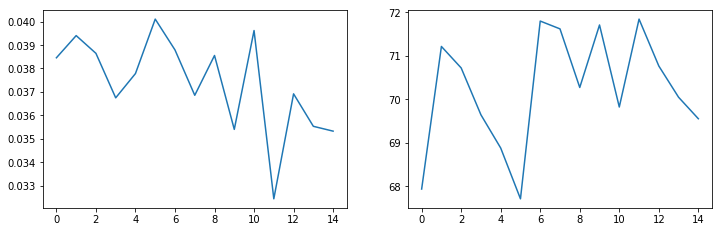

Epoch 65 =>  Val acc: 69.55156950672647


In [68]:
train_tf = T.Compose([
    T.ToTensor(),
    T.RandomOrder([
        T.RandomChoice([
            T.RandomHorizontalFlip(p=1),
            T.RandomVerticalFlip(p=1),
        ]),
        T.RandomRotation(90),
        T.RandomErasing(p = 1, value = 'random'),
        T.RandomPerspective()
    ])
    
])
clip_dataset_train=ActionClipDataset(root_dir='./data/trainClips/',labels=label_train,transform=train_tf)

clip_dataloader_train = DataLoader(clip_dataset_train, batch_size=8,
                        shuffle=True, num_workers=0)
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=8,
                        shuffle=False, num_workers=0)

num_epochs = 15
train_losses = []
val_losses = []
val_accs = []
best_acc = 72.28
PATH = 'saved_models/3d_{}.pt'
for epoch in range(num_epochs):
    losses = []
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(clip_dataloader_train):    
        model.train()

        x_var = sample['clip'].type(dtype)
        y_var = sample['Label'].type(dtype).long()
        
        
        model = model.type(dtype)
        
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)

        loss = loss_fn(scores.cpu(), y_var.cpu())
        if (t + 1) % 200 == 0:
            print('t = %d, loss = %.4f' % (t + 1, loss.data.item()))
        losses.append(loss.data.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
    train_losses.append(np.mean(np.array(losses)))
    acc = check_accuracy_3d(model, clip_dataloader_val, pretrained=pretrained)

    val_losses.append(np.mean(np.array(losses)))
    
    val_accs.append(acc)
    if epoch > 0:
        clear_output(True)
        plt.figure(figsize=(12, 8))
        plt.subplot(221)
        plt.plot(train_losses)
        plt.subplot(222)
        plt.plot(val_accs)
        plt.show()
        print("Epoch", epoch+51, "=> ", "Val acc:", acc)
    if acc > best_acc:
        best_acc = acc
        torch.save(model, PATH.format(str(acc)[:5]))

In [23]:
clean()

In [64]:
fixed_model_3d = torch.load('saved_models/3d_72.28.pt')
fixed_model_3d.eval() 
fixed_model_3d = fixed_model_3d.type(dtype)
check_accuracy_3d(fixed_model_3d, clip_dataloader_val, pretrained=pretrained)

Got 1612 / 2230 correct (72.29)


72.28699551569507

In [65]:
clip_dataset_test=ActionClipDataset(root_dir='./data/testClips/',labels=[],transform=T.ToTensor())
clip_dataloader_test = DataLoader(clip_dataset_test, batch_size=1,
                        shuffle=False, num_workers=0)
count=predict_on_test_3d(fixed_model_3d, clip_dataloader_test)
print(count)

3270


In [ ]:
num_classes = 101
pretrained = resnet.resnet18(
                num_classes=num_classes,
                shortcut_type='A',
                sample_size=112,
                sample_duration=3)
train_tf = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=[114.7748 , 107.7354, 99.4750], std=[38.7568578, 37.88248729, 40.02898126])
])
pretrained = nn.DataParallel(pretrained, device_ids=None)
pretrain = torch.load('./resnet-18-kinetics.pth')
pretrained.load_state_dict(pretrain['state_dict'])

clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16,
                        shuffle=True, num_workers=0)

check_accuracy_3d(pretrained, clip_dataloader_val, pretrained=None)

In [ ]:
train_tf = T.Compose([
    T.Resize(200,200),
    T.ToTensor(),
    T.Normalize(mean=[114.7748 , 107.7354, 99.4750], std=[38.7568578, 37.88248729, 40.02898126])
])
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16,
                        shuffle=True, num_workers=0)
for i in clip_dataloader_val:
    print(i['clip'].shape)
    break

In [ ]:
train_tf = T.Compose([
    T.Resize(112),
    T.ToTensor(),
    T.Normalize(mean=[114.7748 , 107.7354, 99.4750], std=[38.7568578, 37.88248729, 40.02898126])
])

clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=train_tf)

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=16,
                        shuffle=True, num_workers=0)

model = model.type(dtype)
print('started')
check_accuracy_3d(model, clip_dataloader_val)

In [28]:
def check_accuracy_3d(model, loader, pretrained=None):
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    dtype = torch.cuda.FloatTensor
    for t, sample in enumerate(loader):
        if t+1 % 1 == 0:
            print('wait')
        x_var = Variable(sample['clip'].type(dtype))
        y_var = sample['Label'].type(dtype)
        model = model.type(dtype)
        y_var=y_var.cpu()
        if pretrained:
            pretrained = pretrained.type(dtype)
            x_var = pretrained(x_var)
        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds.numpy() == y_var.numpy()).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc * 100

In [9]:
import torchvision
# a = torchvision.models.video.r3d_18(pretrained=True)

In [29]:
clip_dataset_val=ActionClipDataset(root_dir='./data/valClips/',labels=label_val,transform=T.ToTensor())

clip_dataloader_val = DataLoader(clip_dataset_val, batch_size=1,
                        shuffle=False, num_workers=0)

check_accuracy_3d(a, clip_dataloader_val, pretrained=None)

wait
Got 0 / 2230 correct (0.00)


0.0

In [32]:
a.fc = nn.Linear(512, 10)

In [33]:
model = a
model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
dtype = torch.cuda.FloatTensor
for t, sample in enumerate(clip_dataloader_val):
    if t+1 % 1 == 0:
        print('wait')
    x_var = Variable(sample['clip'].type(dtype))
    y_var = sample['Label'].type(dtype)
    model = model.type(dtype)
    y_var=y_var.cpu()
    scores = model(x_var)
    _, preds = scores.data.cpu().max(1)
    print(preds)

wait
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])
tensor([2])

KeyboardInterrupt: 

In [22]:
for i in clip_dataloader_val:
    print(a(i['clip']))
#     a
    break

RuntimeError: _thnn_conv3d_forward not supported on CPUType for Byte